<a href="https://colab.research.google.com/github/johanhoffman/DD2363_VT23/blob/juliusha/Lab4/report_lab_4_juilus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 4: Integration**
**Julius Häger**

# **Abstract**

In this lab report I implement 2 weighted sum integration methods, one over a unit interval and one over a reference triangle, as well as 2 monte carlo integration methods, over the same unit interval and reference triangle.

#**About the code**

In [ ]:
"""This program is lab report in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2023 Julius Häger (juliusha@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [ ]:
# Load neccessary modules.
from google.colab import files

import time
import numpy as np

from IPython.display import display, Math

from typing import Callable, Tuple


#try:
#    from dolfin import *; from mshr import *
#except ImportError as e:
#    !apt-get install -y -qq software-properties-common 
#    !add-apt-repository -y ppa:fenics-packages/fenics
#    !apt-get update -qq
#    !apt install -y --no-install-recommends fenics
#    from dolfin import *; from mshr import *
    
#import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt
from matplotlib import tri
from matplotlib import axes
from mpl_toolkits.mplot3d import Axes3D

from scipy import integrate


# **Introduction**

Numerical integration is useful in a lot of contexts. Some functions don't have analytical expressions for their integrals, other times you don't know the exact function that is going to be integrated. Numerical integration can also be very helpful in solving differential equations.

For example to solution to the differential equation $u'(x) = f(x),\, x \in [a, b]$ is given by $u(x) = u(a) + \int_{a}^{x}f(y)dy$, this can easily be calculated thorugh numerical integration.

One method of numerical integration called the Gauss quadrature uses $q+1$ function evaluations to calculate the exact integral of polynomials of up to degree $2q+1$. It achives this by evaluating the functions at specific points and doing a weighted sum. For higher dimentional integrations $(q+1)^d$ evaluation points are needed, where $d$ is the number of dimentions.

For large dimentional spaces this becomes impractical. A method that doesn't suffer from many dimentions is Monte Carlo integration. Monte Carlo integration is a Monte Carlo method which uses random samples to converge on a numerical value, in this case the integral.

# **Method**

## Assignment 1: 2-point Gauss quadrature over a unit interval



The 2-point Gauss quadrature uses the fact that a polynomial $p(x)$ can be factorized like the following $p(x) = \phi(x)s(x) + r(x)$ where $\phi(x)$ is a $q+1$ degree polynomial with $q+1$ distinct zeros $x_i \in [a, b]$ and is orthogonal to all polynomials of degree $q$.
$$\int_{a}^{b} \phi(x)s(x)\,dx = 0, ~~~~ \forall_s \in \mathcal{P}^d([a,b])$$

By chosing evaluation points where $\phi(x_i) = 0$ which results in $p(x_i) = r(x_i)$. This can then be used to show the following equality<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1):
$$
\int_{a}^{b} p(x) \, dx = \sum_{i=0}^{q} p(x_i)w_i
$$

Using the above equality we can figure out the evalution points for $q+1=2$ on $[-1, 1]$ to be $x_0 = 1/\sqrt{3}$ and $x_1 = -1/\sqrt{3}$, and the weights to be $w_0 = w_1 = 1$. To get this to the unit interval $[0, 1]$ we need to remap the interval $[-1, 1]$ onto the unit interval which can be done by $(x + 1) / 2, x \in [-1, 1]$ and multiplying by the ratio of size $|[0, 1]|/|[-1, 1]|=1/2$. This gets us $x_0 = \frac{1}{2}-\frac{\sqrt{3}}{6}$ and $x_1 = \frac{1}{2}+\frac{\sqrt{3}}{6}$. This allows us to quite easily compute the 2-point quadrature over the unit interval.

<a name="cite_note-1"></a>1. [^](#cite_ref-1) Methods in Computational Science, Chapter 11: Integration methods, p.237-258 https://epubs.siam.org/doi/abs/10.1137/1.9781611976724.ch11

In [ ]:
# Assignment 1: 2-point Gauss quadrature over a unit interval

def GaussQuad2Point(f : Callable[[np.double], np.double]):
  sqrt3div6 = np.sqrt(3) / 6
  return (f(0.5 - sqrt3div6) + f(0.5 + sqrt3div6)) * 0.5

As we can see the resulting code is very simple. By changing the integration interval this method can easily be extended to create a composite 2-point gauss quadrature.

## Assignment 2: 3-point edge midpoint quadrature over a reference triangle

For triangles a 3-point edge midpoint quadrature can be constructed with similar methods to the previous 2-point Guass quadrature. This methods evaluates the midpoints of the triangles sides and weights them with weights $w_0 = w_1 = w_2 = 1/6$.

In [ ]:
# Assignment 2: 3-point edge midpoint quadrature over a reference triangle

def EdgeMidpointQuadrature3point(f : Callable[[Tuple[np.double, np.double]], np.double]):
  sum = f((0.5, 0)) + f((0, 0.5)) + f((0.5, 0.5))
  return sum / 6


Extending this method to create a composite method is not as straight forward as it is with the 2-point Gauss quadrature. We need to create a linear transformation $F$ from the triangle we want to integrate to the reference triangle use and then scale the result using $|\mathrm{det}(F')|$ where $F'$ is the jacobian of $F$.

## Assignment 3: Monte Carlo quadrature over unit interval

Monte Carlo integration is based on the law of large numbers that states that the mean of an ever increasing number of samples from a random variable $X$ will converge towards the expected value $E(X)$. This is used to relate the mean of a number of samples to the expected value.
$$
\overline{f}=\frac{1}{n}\sum_{i=1}^{n}g(x_i) \approx E[f] = \frac{1}{|D|}\int_{D} f(x) \,dx
$$

This gives a really simple way to compute the integral of the function $f(x)$ by repeatedly sampling random points from the integration interval and taking the mean of the samples multiplied by the size of the interval.

In [ ]:
# Assignment 3: Monte Carlo quadrature over a unit interval

def MonteCarloUnitInterval(f : Callable[[np.ndarray], np.ndarray], samples : int):
  xs = np.random.rand(samples)
  ys = f(xs)
  return np.mean(ys)



This method is almost trivial to extend into multiple dimentions only requiring a way to sample points uniformly over the integration domain, and a way to measure the size of the domain. This is why Monte Carlo integration can scale well to multiple dimentions while the Gauss-like quadratures could not scale gracefully.

## Extra Assignment: Monte Carlo quadrature over a reference triangle

As mentioned in the previous assignment, to extend Monte Carlo integration to multiple dimentions is a way to sample locations on the integration domain uniformly and the ability to determine the domains size. In this assignment the integration domain is a reference triangle with area $1/2$. To sample uniform points on this triangle we first generate uniform points on the unit square. For all points outside the unit triangle we use a double reflection to rotate the points 180° around the center of the unit square which maps these points back onto the reference triangle.

Aside from the different way of finding random samples and the different domain size the method remains exactly the same as the previous one.

In [ ]:
# Extra Assignment: Monte Carlo quadrature over a reference triangle

def MonteCarloRefTriangle(f : Callable[[np.ndarray, np.ndarray], np.ndarray], samples : int):
  xs = np.random.rand(samples)
  ys = np.random.rand(samples)
  ygtx = ys > (1 - xs)
  np.subtract(1, xs, out=xs, where=ygtx)
  np.subtract(1, ys, out=ys, where=ygtx)

  fs = f(xs, ys) * 0.5

  return np.mean(fs)

Vague correlation to $1 / \sqrt{x}$. TODO

# **Results**

## Assignment 1: 2-point Gauss quadrature over a unit interval

To check the accuracy of the 2-point Gauss quadrature we can compare the result to the analytically calculated value of the integral.

In [ ]:
p = lambda x : 3*(x**3) - 3*(x**2) - 3*x + 1

# Wolfram Alpha: https://www.wolframalpha.com/input?i=integral+from+0+to+1+of+3x%5E3+-+3x%5E2+-+3x+%2B+1
exact_integral = -3.0/4.0

calculated_integral = GaussQuad2Point(p)

diff = np.abs(calculated_integral - exact_integral)

display(Math(rf"| \mathrm{{gq2p}} - \mathrm{{exact}} | = {diff}"))

<IPython.core.display.Math object>

As we can see for a cubic polynomial the 2-point Gauss quadrature gives an exact result.

## Assignment 2: 3-point edge midpoint quadrature over a reference triangle

A similar method can use used to evaluate the accuracy of the 3-point edge midpoint quadrature. We compare the value of the integral to an analytically calculated integral value.

In [ ]:
p = lambda x : 2*x[0] + x[1]**2

# Wolfram Alpha: https://www.wolframalpha.com/input?i=integral+from+0+to+1+of+integral+from+0+to+1-y+of+2*x%2By%5E2+dx+dy
exact_integral = 5 / 12

computed_integral = EdgeMidpointQuadrature3point(p)

diff = np.abs(computed_integral - exact_integral)

display(Math(rf"| \mathrm{{emq3p}} - \mathrm{{exact}} | = {diff}"))

<IPython.core.display.Math object>

And similarly here the 3-point method can calculate integrals of quadratic polynomials exactly.

## Assignment 3: Monte Carlo quadrature over unit interval

To evaluate the Monte Carlo integraion method we can compare the calculated value compared to an exact value. We can also look at the convergence rate of the the function as the number of samples taken increases. The expected convergence of the method is $1/\sqrt{n}$.

-0.7508619330337446


<IPython.core.display.Math object>

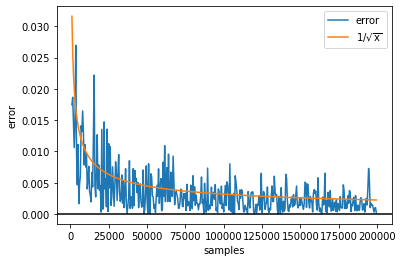

In [ ]:
f = lambda x : 3*(x**3) - 3*(x**2) - 3*x + 1

# Wolfram Alpha: https://www.wolframalpha.com/input?i=integral+from+0+to+1+of+3x%5E3+-+3x%5E2+-+3x+%2B+1
exact_integral = -3.0/4.0

computed_integral = MonteCarloUnitInterval(f, 10_000)

print(computed_integral)

diff = np.abs(computed_integral - exact_integral)

display(Math(rf"| \mathrm{{montecarlo}}_{{10000}} - \mathrm{{exact}} | = {diff}"))

start = 1_000
stop = 200_000
step = 500
no_samples = np.array(range(start, stop, step))
values = np.zeros(len(no_samples))
for i, samples in enumerate(no_samples):
  values[i] = MonteCarloUnitInterval(f, samples)

plt.plot(no_samples, np.abs(exact_integral - values), label="error")
plt.plot(no_samples, (1 / np.sqrt(no_samples)), label=r"$1/\sqrt{\mathrm{x}}$")
plt.axhline(0, color='black')
plt.xlabel("samples")
plt.ylabel("error")
plt.legend()
plt.show()

The error compared to the exact method is larger than the 2-point Gauss quadrature, but the error is less than the expected $1/\sqrt{10\,000} = 0.01$.

We can also see that the error does indeed seem to decrease at the rate $1/\sqrt{n}$.

## Extra Assignment: Monte Carlo quadrature over a reference triangle

<IPython.core.display.Math object>

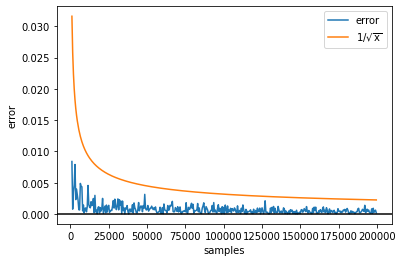

In [ ]:
f = lambda x, y : 2*x + y**2

# Wolfram Alpha: https://www.wolframalpha.com/input?i=integral+from+0+to+1+of+integral+from+0+to+1-y+of+2*x%2By%5E2+dx+dy
exact_integral = 5 / 12

computed_integral = MonteCarloRefTriangle(f, 10_000)

diff = np.abs(computed_integral - exact_integral)

display(Math(rf"| \mathrm{{montecarlo}}_{{10000}} - \mathrm{{exact}} | = {diff}"))

start = 1_000
stop = 200_000
step = 500
no_samples = np.array(range(start, stop, step))
values = np.zeros(len(no_samples))
for i, samples in enumerate(no_samples):
  values[i] = MonteCarloRefTriangle(f, samples)

plt.plot(no_samples, np.abs(exact_integral - values), label="error")
plt.plot(no_samples, (1 / np.sqrt(no_samples)), label=r"$1/\sqrt{\mathrm{x}}$")
plt.axhline(0, color='black')
plt.xlabel("samples")
plt.ylabel("error")
plt.legend()
plt.show()

Similarly to the previous Monte Carlo integration the error compared to the exact value is less than the expected $1 / \sqrt{10\,000} = 0.01$.

We can also see that the error also decreases of a rate proportional to $1 / \sqrt(n)$.

# **Discussion**

The field of numerical integration is wast, and there are many more method for numerical integration that could be dicussed in this lab. This lab also omitted any implementations of composite integration methods which are often used for large multi-dimentional input domains.

Other variations of Monte Carlo integration could also have been dicussed such as importance sampling and multiple importance sampling which are often used in graphics applications to efficiently approximate the integral of a *bidirectional reflectance distribution function* (BRDF) on a hemisphere domain.